# YOLOv8n Vessel Detection Model Evaluation

## 1. Setup

In [2]:
# Better error messages in notebooks
%load_ext autoreload
%autoreload 2

In [3]:
# Set up data paths
from pathlib import Path
import sys

# Get to project root from notebook location
PROJECT_ROOT = Path.cwd().parent
# Add "src" to Python's module search path sys.path
sys.path.append(str(PROJECT_ROOT / "src"))
sys.path.append("/home/peterm/UWA/CITS5014/SARFish/working")

# Define project paths
DATA_DIR = PROJECT_ROOT / "data"
CONFIG_DIR = PROJECT_ROOT / "configs"
RUNS_DIR = PROJECT_ROOT / "runs"

print(f"PROJECT_ROOT: {PROJECT_ROOT}")
print(f"DATA_DIR:     {DATA_DIR}")
print(f"CONFIG_DIR:   {CONFIG_DIR}")
print(f"RUNS_DIR:     {RUNS_DIR}")

PROJECT_ROOT: /home/peterm/UWA/CITS5014/SARFish/modelling
DATA_DIR:     /home/peterm/UWA/CITS5014/SARFish/modelling/data
CONFIG_DIR:   /home/peterm/UWA/CITS5014/SARFish/modelling/configs
RUNS_DIR:     /home/peterm/UWA/CITS5014/SARFish/modelling/runs


In [4]:
%matplotlib inline
import numpy as np
import pandas as pd
import yaml
import pickle
import matplotlib.pyplot as plt
from datetime import datetime
from ultralytics import YOLO
from utilities import *
from plot_loss_curves import plot_total_loss
from du_utilities import *

## 2. Vessel detection model evaluation on test data

The original 96 x 96 pixel training dataset was augmented as a way of addressing the problem of class imbalance in the data. Several geometric transforms (horizontal flip, vertical flip, 90, 180 and 270 degree anti-clockwise rotation and translation) were applied to the image crops in varying combination. In addition, composite images or 'mosaics' were  generated to expand the dataset even further. Augmentation was applied to the raw image crops prior to processing. The best performing pretrained YOLOv8n model configuration used to train the augmented and processed dataset is shown below. Note that 'in situ' augmentation or augmentation while training, was also applied.

### 2.1 Set up model paths

The yaml file below describes the data sources usd to train the best model (Run# 20250818_1835)

In [4]:
# Save to configs directory
yaml_path = CONFIG_DIR / 'png_aug_dual.yaml'
with open(yaml_path, 'r') as f:
    data = yaml.safe_load(f)
print(data)

{'names': ['is_vessel', 'is_fishing'], 'nc': 2, 'path': '/home/peterm/UWA/CITS5014/SARFish/modelling/data', 'test': 'test_dual', 'train': 'train_hvrt_msc_bal_dual', 'val': 'val_dual'}


In [4]:
# Define the path to the best model for retrieval
results_path = RUNS_DIR / 'png_runs' / 'png_aug_dual' / '20250915_1358_30042'

In [5]:
# Define the path to the best model
model_path=results_path / 'weights' / 'best.pt'
print(model_path)

/home/peterm/UWA/CITS5014/SARFish/modelling/runs/png_runs/png_aug_dual/20250915_1358_30042/weights/best.pt


### 2.2 Evalute model on the test set:

In [8]:
yaml_path = CONFIG_DIR / 'png_aug_dual.yaml'
eval_path = results_path / "evaluation"
print(yaml_path)
print(eval_path)

/home/peterm/UWA/CITS5014/SARFish/modelling/configs/png_aug_dual.yaml
/home/peterm/UWA/CITS5014/SARFish/modelling/runs/png_runs/png_aug_dual/20250915_1358_30042/evaluation


In [9]:
# Load the model
model = YOLO(model_path)

# Run validation with Ultralytics defaults
test_results = model.predict(
    data=yaml_path,  # data.yaml file from training
    project=eval_path,
    split='test',
    conf=0.25,       # default Ultralytics validation!
    iou=0.7,         # Default IoU threshold for NMS
    plots=True,
    verbose=True
)

Ultralytics 8.3.152 🚀 Python-3.10.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 2000 Ada Generation Laptop GPU, 8188MiB)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 96.1±12.6 MB/s, size: 25.5 KB)


val: Scanning /home/peterm/UWA/CITS5014/SARFish/modelling/data/test_dual/labels... 253 images, 0 backgrounds, 0 corrupt:


val: New cache created: /home/peterm/UWA/CITS5014/SARFish/modelling/data/test_dual/labels.cache


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<


                   all        253        253      0.595      0.529      0.528      0.269
             is_vessel        221        221      0.799      0.652      0.746      0.408
            is_fishing         32         32      0.391      0.406       0.31      0.129
Speed: 1.0ms preprocess, 3.4ms inference, 0.0ms loss, 3.0ms postprocess per image
Results saved to /home/peterm/UWA/CITS5014/SARFish/modelling/runs/png_runs/png_aug_dual/20250915_1358_30042/evaluation/val


In [25]:
df = test_results.to_df()
df  # DO NOT USE - last three columns are wrong!

,class_name,box-p,box-r,box-f1,box-map,box-map50,box-map75
0,is_vessel,0.74654,0.73303,0.73973,0.27902,0.55438,0.24956
1,is_fishing,0.34694,0.53125,0.41975,0.27902,0.55438,0.24956


In [1]:
# WIll need to manually extract F1-score using this formula
f1_formula = "F1 = 2 * (Precision * Recall) / (Precision + Recall)"
print(f1_formula) 

F1 = 2 * (Precision * Recall) / (Precision + Recall)


In [2]:
2 * (0.747 * 0.733) / (0.747 + 0.733)

0.7399337837837838

### 2.3 Confusion Matrix

In [19]:
# Print the un-normalised confusion matrix
print(test_results.confusion_matrix.to_df())

    Predicted  is_vessel  is_fishing  background
0   is_vessel      166.0         9.0        42.0
1  is_fishing       20.0        18.0        11.0
2  background       35.0         5.0         0.0


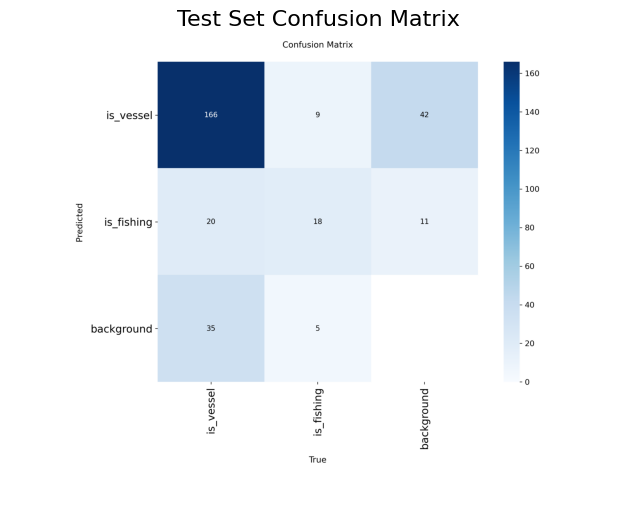

In [20]:
# Load and display the confusion matrix
img_path = eval_path / 'val' / 'confusion_matrix.png'
img = mpimg.imread(img_path)

plt.figure(figsize=(8, 6))  # Width x Height in inches
plt.imshow(img)
plt.axis('off')  # Optional: hides axis ticks
plt.title('Test Set Confusion Matrix', fontsize=16)
plt.show()

In [5]:
# Define the path to the test images
test_images_path = '/mnt/h/SARFish/Generated/SLC/test/crops_png_dual/images'
test_labels_path = '/mnt/h/SARFish/Generated/SLC/test/crops_png_dual/labels'
test_images_list = list(Path(test_images_path).glob("*.png"))
print(test_images_path)
print(test_labels_path)

/mnt/h/SARFish/Generated/SLC/test/crops_png_dual/images
/mnt/h/SARFish/Generated/SLC/test/crops_png_dual/labels


In [6]:
# Define the path to the best model for retrieval
results_path = RUNS_DIR / 'png_runs' / 'png_aug_dual' / '20250915_1358_30042'
eval_path = Path(results_path / 'evaluation')
print(eval_path)

/home/peterm/UWA/CITS5014/SARFish/modelling/runs/png_runs/png_aug_dual/20250915_1358_30042/evaluation


In [7]:
# Define the path to the best model
model_path=results_path / 'weights' / 'best.pt'
print(model_path)

/home/peterm/UWA/CITS5014/SARFish/modelling/runs/png_runs/png_aug_dual/20250915_1358_30042/weights/best.pt


In [12]:
# Perfom inference on test images and save the predicted labels with confidence scores

model = YOLO(model_path)

# Run inference
results = model.predict(source=test_images_path,
                        project=eval_path,
                        conf=0.04,        # adjusted minimum confidence threshold for detection
                        iou=0.65,         # default IoU threshold for NMS
                        save=True,
                        verbose=False
)

# Save label predictions with confidence score
for r in results:
    img_path = Path(r.path)
    stem = img_path.stem
    out_path = eval_path / f"preds/{stem}_pred.txt"
    r.save_txt(out_path, save_conf=True)


Results saved to /home/peterm/UWA/CITS5014/SARFish/modelling/runs/png_runs/png_aug_dual/20250915_1358_30042/evaluation/predict


In [110]:
# Base directory where all runs are stored
base_dir = Path("/home/peterm/UWA/CITS5014/SARFish/modelling/runs/png_runs/")
model_ids = ["20250915_1155_30019", "20250915_1358_30042", "20250918_2332_30950", "20250818_1835"]

model_path_list = []
for model_id in model_ids:
    matches = list(base_dir.glob(f"*/{model_id}*/weights/best.pt"))
    model_path_list.extend(matches)

print(f"Found {len(model_path_list)} models:")
for p in model_path_list:
    print(p)

Found 4 models:
/home/peterm/UWA/CITS5014/SARFish/modelling/runs/png_runs/png_aug_dual/20250915_1155_30019/weights/best.pt
/home/peterm/UWA/CITS5014/SARFish/modelling/runs/png_runs/png_aug_dual/20250915_1358_30042/weights/best.pt
/home/peterm/UWA/CITS5014/SARFish/modelling/runs/png_runs/png_aug_dual/20250918_2332_30950/weights/best.pt
/home/peterm/UWA/CITS5014/SARFish/modelling/runs/png_runs/png_aug_bal/20250818_1835/weights/best.pt


In [111]:
def conf_sweep(model_path, test_images, conf_levels):
    """
    Run inference for one model over a set of confidence levels.
    """
    model = YOLO(model_path)
    records = []

    print(f"\nEvaluating model: {model_path}")

    for conf in conf_levels:
        preds = model.predict(
            source=test_images,
            conf=conf,
            iou=0.7,
            verbose=False)

        total_detections = sum(len(r.boxes) for r in preds)

        #print(f"conf={conf:.2f} → detections={total_detections}")

        records.append({
            "model": Path(model_path).parents[1].name,
            "conf": conf,
            "detections": total_detections
        })

    return pd.DataFrame(records)


In [112]:
conf_levels = np.arange(0.04, 0.36, 0.02)

dfs = []
for model_path in model_path_list:
    df = conf_sweep(model_path, test_images_path, conf_levels)
    dfs.append(df)

all_model_sweep_df = pd.concat(dfs, ignore_index=True)


Evaluating model: /home/peterm/UWA/CITS5014/SARFish/modelling/runs/png_runs/png_aug_dual/20250915_1155_30019/weights/best.pt

Evaluating model: /home/peterm/UWA/CITS5014/SARFish/modelling/runs/png_runs/png_aug_dual/20250915_1358_30042/weights/best.pt

Evaluating model: /home/peterm/UWA/CITS5014/SARFish/modelling/runs/png_runs/png_aug_dual/20250918_2332_30950/weights/best.pt

Evaluating model: /home/peterm/UWA/CITS5014/SARFish/modelling/runs/png_runs/png_aug_bal/20250818_1835/weights/best.pt


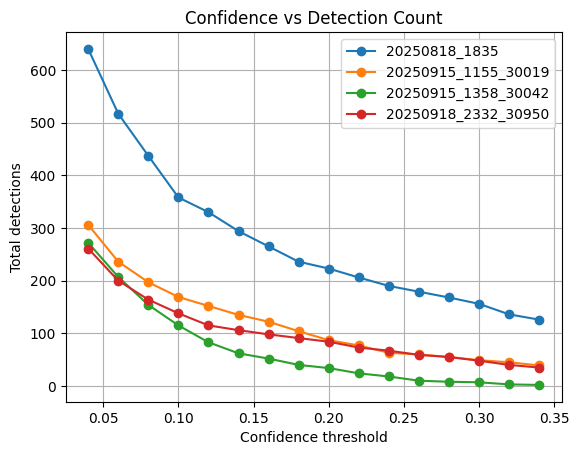

In [113]:
for model_name, grp in all_model_sweep_df.groupby("model"):
    plt.plot(grp["conf"], grp["detections"], marker="o", label=model_name)

plt.xlabel("Confidence threshold")
plt.ylabel("Total detections")
plt.title("Confidence vs Detection Count")
plt.legend()
plt.grid(True)
plt.show()

**Comment:**

blue curve (20250818_1835): previous best model, judged on YOLO validation metrics,  uses the channel input (amp, phase, zeros)
orange curve (20250915_1155_30019): best model, judged on YOLO validation metrics, uses the channel input (vv_mag, vh_mag, pcf_mag)
green curve (20250915_1358_30042): same as orange but uses LR scheduler + early-stopping, very similar performance metrics
red curve (20250918_2332_30950): same as orange but uses gaussian filtering, relatively lower perfromance metrics

test set only has 253 ground truth labels, blue curve predicts many more detections across the entire range cmpared to the other three models.

Difficult to interpret model performance on this plot alone.
 


### 2.4 Visualisation: test predictions vs ground truth

Found 463 images. Displaying 5 randomly selected images:



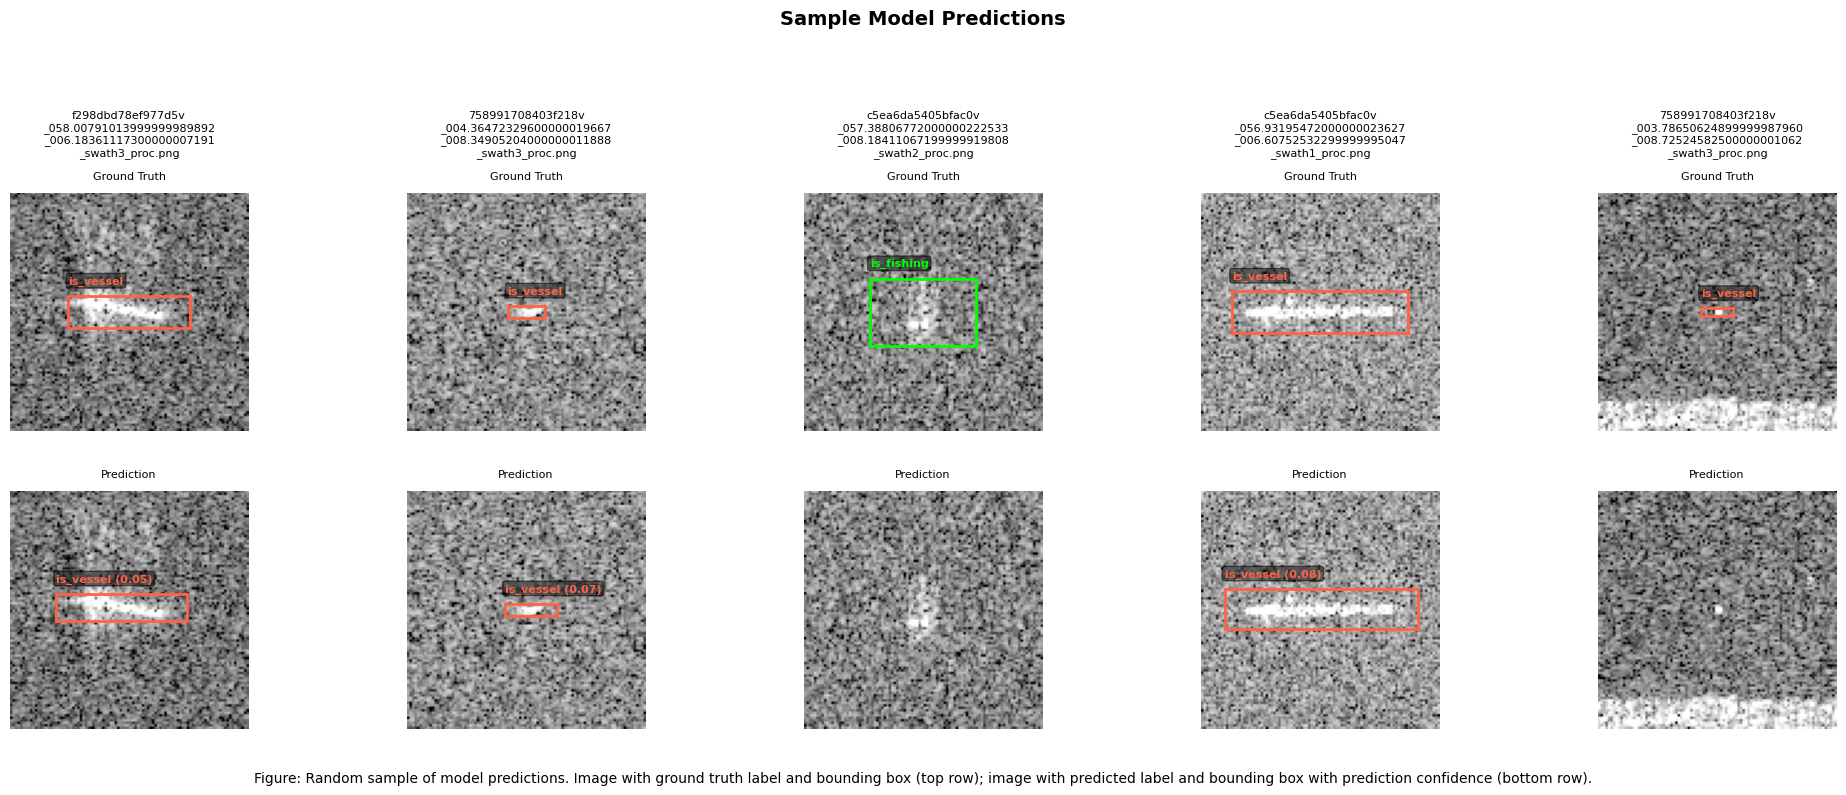

In [58]:
model = YOLO(model_path)

from compare_inference_results import create_sar_prediction_comparison
create_sar_prediction_comparison(model, test_images_path,
                                 labels_path=test_labels_path,
                                 project=eval_path,
                                 conf=0.05,
                                 iou=0.7,
                                 verbose=False,
                                 num_images=5,
                                 save_path=None
)

In [27]:
# Specify test image directory
test_images_path = DATA_DIR / "test_alt" / "images"

Found 253 images. Displaying 6 randomly selected images:



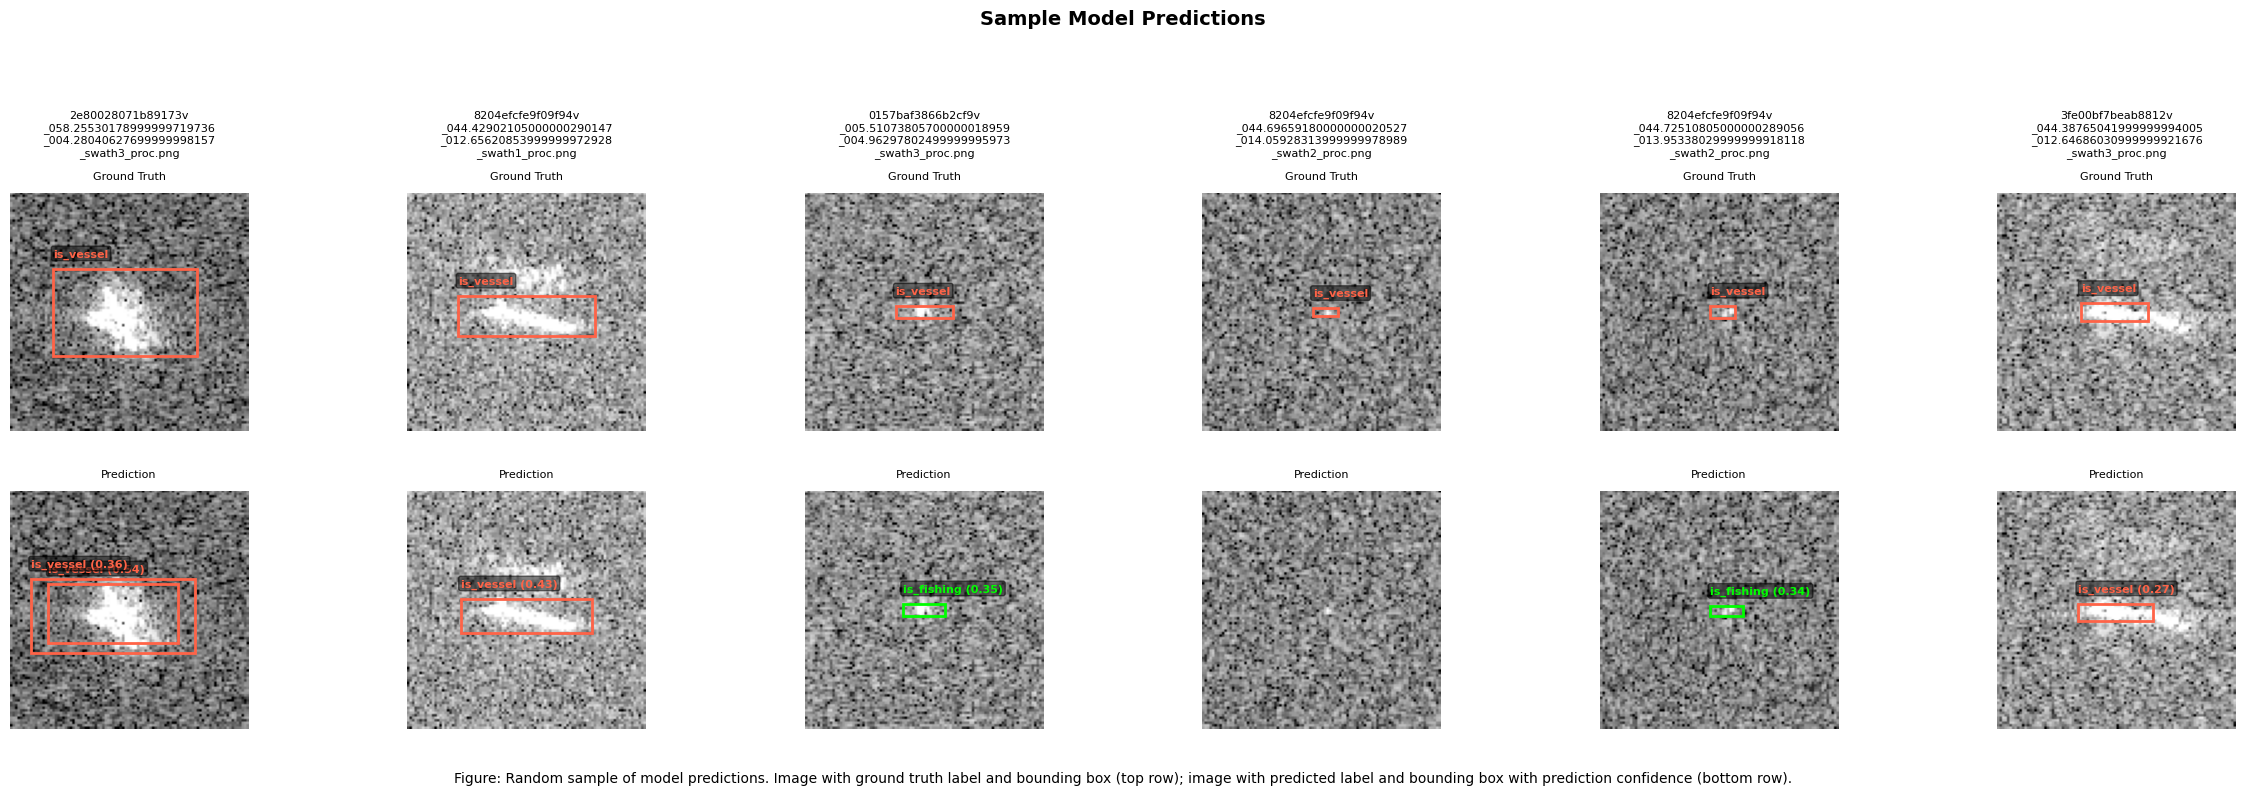

In [21]:
# Randomely select six test images to display
model = YOLO(model_path)
create_sar_prediction_comparison(model, test_images_path, num_images=6)